In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization

In [2]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"/home/fenris/McCoy_Group/conv/h2o_dmc/h2o_training_data/training_{time}.hdf5")
        print(cds.shape)
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v


def plot_training_data(cds, pots):
    plt.scatter(cds, pots)

def clean_training_data(train_x, train_y,diffmat):
    threshold = 0.001
    # death_matels = np.zeros(diffmat.shape)
    final_x = np.zeros(train_x.shape)
    for row_num,row in enumerate(diffmat):
        #calculate threshold
        diffz = row[row_num+1:]
        death_mark = np.abs(diffz) < threshold
        final_x += np.concatenate((np.zeros(row_num+1),death_mark))
        # death_matels[row_num, np.where(death_mark)[0]] = 1
    np.delete(train_x, final_x)
    np.delete(train_y, final_x)
    print('hi')
    train_x

def difference_matrix(train_x):
    x = np.reshape(train_x, (len(train_x), 1))
    return x - x.transpose()

def internals_h2O(cds):
    analyzer = AnalyzeWfn(cds)
    bl1 = analyzer.bond_length(0,2)
    bl2 = analyzer.bond_length(1,2)
    theta = analyzer.bond_angle(0,2,1)
    return np.array((bl1,bl2,theta)).T

tss = np.arange(18)
train_x, train_y = get_ml_data(tss)
train_x = internals_h2O(train_x)

val_set = [19]
val_x, val_y = get_ml_data(val_set)
val_x = internals_h2O(val_x)

(19960, 3, 3)
(19995, 3, 3)
(19961, 3, 3)
(20016, 3, 3)
(19980, 3, 3)
(19973, 3, 3)
(20020, 3, 3)
(19960, 3, 3)
(19940, 3, 3)
(19995, 3, 3)
(19984, 3, 3)
(20004, 3, 3)
(19982, 3, 3)
(19977, 3, 3)
(19978, 3, 3)
(19984, 3, 3)
(19980, 3, 3)
(19960, 3, 3)
(19961, 3, 3)


In [3]:
X_MIN = 0
X_MAX = 4

def plot_result(val_x, val_y, history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
#    ax_data = fig.add_subplot(212)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
#     ax_data.scatter(val_x,val_y)
#     ax_data.scatter(val_x, model.predict(val_x), marker='|')
#     ax_data.legend(['Analytic', 'Predicted'], loc='upper right')
    
    plt.show()

def normalize_x(x):
    return 2*(x-X_MIN)/(X_MAX-X_MIN)-1

train_x = normalize_x(train_x)
val_x = normalize_x(val_x)

In [11]:
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(3,)),
        Dense(64, activation=tf.nn.swish),
        Dense(64, activation=tf.nn.swish),
        Dense(64, activation=tf.nn.swish),
        Dense(1, activation='linear')
    ]
)

model.load_weights('h2o_3x64.h5')

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=100000, decay_rate=0.8, staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

print(model.summary())

In [ ]:
history = model.fit(train_x, np.log10(train_y), validation_split=0.1, batch_size=32, epochs=5)

Epoch 1/5
10116/10116 [==============================] - 19s 2ms/step - loss: 2.7840e-06 - val_loss: 1.1863e-06
Epoch 2/5
10116/10116 [==============================] - 19s 2ms/step - loss: 2.7139e-06 - val_loss: 1.4266e-06
Epoch 3/5
10116/10116 [==============================] - 19s 2ms/step - loss: 2.6785e-06 - val_loss: 1.3307e-06
Epoch 4/5
10116/10116 [==============================] - 19s 2ms/step - loss: 2.3820e-06 - val_loss: 1.1174e-06
Epoch 5/5
 7003/10116 [===================>..........] - ETA: 5s - loss: 3.4081e-06

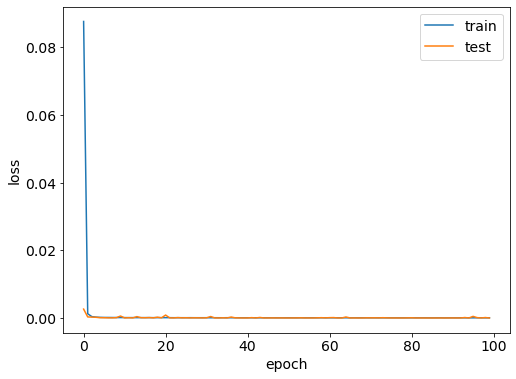

In [65]:
plot_result(val_x, val_y, history, model)

In [32]:
print("       Label        Predicted")
val_data = np.concatenate((np.expand_dims(val_y, axis=1), 10**model.predict(val_x)),axis=1)
print(val_data[:10])

       Label        Predicted
[[29976.36787308 30065.36328125]
 [ 1522.17398299  1524.96948242]
 [25577.11931292 25628.48242188]
 [11165.33339681 11167.09570312]
 [ 5494.91537363  5502.81103516]
 [26979.94440093 26972.93554688]
 [ 1191.22178834  1189.79040527]
 [11532.9451041  11524.56445312]
 [12370.87012885 12376.20410156]
 [ 8746.98425919  8734.2578125 ]]


(-0.001, 0.02)

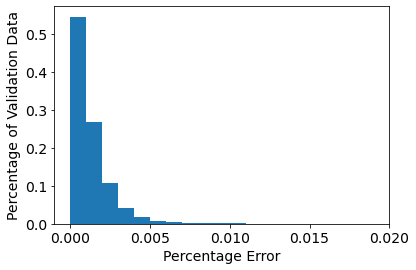

In [33]:
weights = np.ones_like(val_data[:,0]) / len(val_data[:,0])
plt.hist(np.abs(val_data[:,0]-val_data[:,1])/val_data[:,0], bins=np.arange(0,1,0.001), weights=weights)
plt.xlabel('Percentage Error')
plt.ylabel('Percentage of Validation Data')
plt.xlim((-0.001,0.02))

In [34]:
model.save_weights('h2o_3x64.h5')

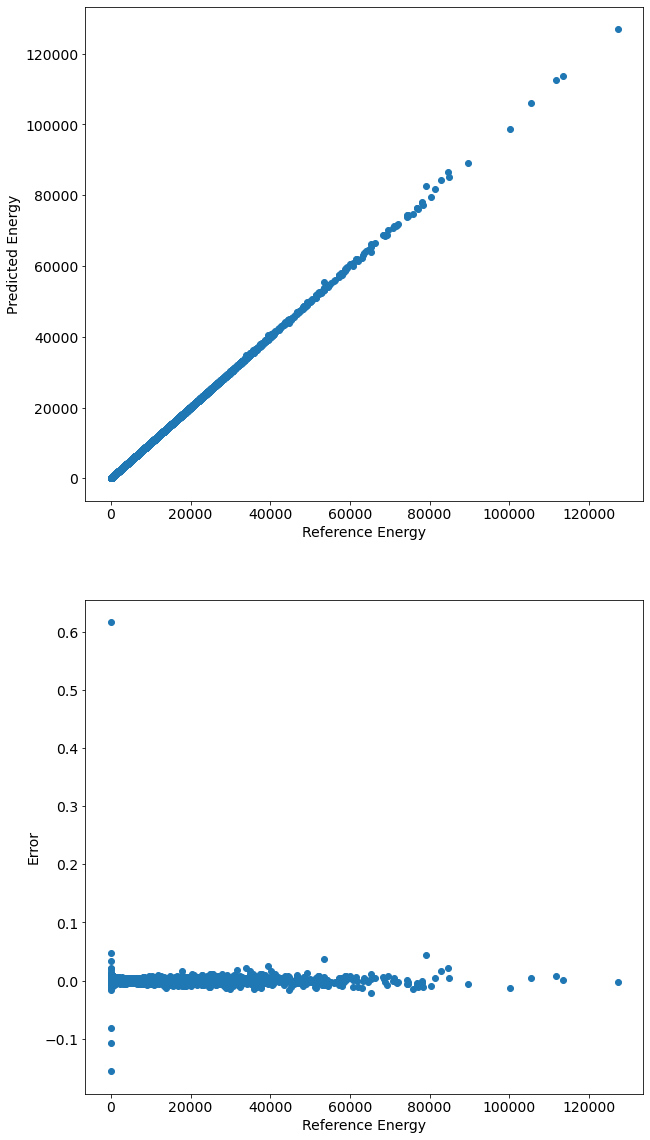

In [35]:
def plot_dis_vec(x1, x2):
    fig = plt.figure(figsize=(10,20))

    loss = fig.add_subplot(2,1,1)
    loss.scatter(x1, x2)
    loss.set_xlabel('Reference Energy')
    loss.set_ylabel('Predicted Energy')
    
    percent_loss = fig.add_subplot(2,1,2)
    percent_loss.scatter(x1, (x2-x1)/x1)
    percent_loss.set_xlabel('Reference Energy')
    percent_loss.set_ylabel('Error')
    #percent_loss.set_ylim((-0.2,0.2))
    #percent_loss.set_xlim((0,100))
    plt.show()
    
plot_dis_vec(val_data[:,0], val_data[:,1])